## Import the required packages

In [1]:
# General
import os
import numpy as np
import pandas as pd
import nltk

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Model training
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf

# LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Model evaluation
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

2024-07-04 12:56:54.228172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the dataset

### Function to load reviews from a directory

In [2]:
def load_reviews(directory, label):
    reviews = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                review = file.read()
                reviews.append((review, label))
    return reviews

### Load the training data

In [3]:
train_pos = load_reviews('/Users/achshahrm/Documents/IU International/Sem 04/Project NLP/Dataset/train/pos', 1)
train_neg = load_reviews('/Users/achshahrm/Documents/IU International/Sem 04/Project NLP/Dataset/train/neg', 0)

### Load the testing data

In [4]:
test_pos = load_reviews('/Users/achshahrm/Documents/IU International/Sem 04/Project NLP/Dataset/test/pos', 1)
test_neg = load_reviews('/Users/achshahrm/Documents/IU International/Sem 04/Project NLP/Dataset/test/neg', 0)

### Combine into dataframes

In [5]:
train_data = pd.DataFrame(train_pos + train_neg, columns=['review', 'label'])
test_data = pd.DataFrame(test_pos + test_neg, columns=['review', 'label'])

data = pd.concat([train_data, test_data], ignore_index=True)
print(data.shape)

(50000, 2)


## Inspecting the dataframes

In [6]:
data.head(10)

,review,label
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1
5,I saw the movie with two grown children. Altho...,1
6,You're using the IMDb.<br /><br />You've given...,1
7,This was a good film with a powerful message o...,1
8,"Made after QUARTET was, TRIO continued the qua...",1
9,"For a mature man, to admit that he shed a tear...",1


In [7]:
data.tail(10)

,review,label
49990,Loving the Andersen fairy tails as a child and...,0
49991,"Like a lot of people, I loved the original; ""A...",0
49992,"I won't lie, I rented this film because it was...",0
49993,"This movie should have been called ""The Eyes o...",0
49994,There are places for political commentary in f...,0
49995,With actors like Depardieu and Richard it is r...,0
49996,If you like to get a couple of fleeting glimps...,0
49997,When something can be anything you want it to ...,0
49998,"I had heard good things about ""States of Grace...",0
49999,"Well, this movie actually did have one redeemi...",0


##### Problem
The dataframe seems to be ordered, i.e. grouped, all positive reviews are at the beginning of the dataset and all negative reviews are at the end. This can lead the model to learn from a biased distribution and cause overfitting.
##### Solution
We can shuffle the dataframes to prevent overfitting. Model is forced to generalize better rather than memorize the order of data.

### Shuffle the data

In [8]:
data = data.sample(frac=1).reset_index(drop=True)

## Exploring the data

### Random Sample

In [9]:
data.sample(10)

,review,label
37721,"""The Thief of Bagdad"" is impressive in the sha...",1
33178,This movie felt so real. I actually felt all o...,1
23865,Flipper is a nice heartwarming movie for whole...,1
47113,"This film holds 7.0 rating on IMDb, so even I ...",0
1596,I love this movie. It is one of those movies t...,1
11272,I loved the movie. I loved Timothy Dalton and ...,1
7703,Corridors of time. The movie you can watch if ...,0
22060,SPOILER ALERT! Don't read on unless you're pre...,1
7739,Imagine a woman alone in a house for forty fiv...,0
43018,The movie was to be shown here in Bangkok with...,0


In [10]:
data.head(5)

,review,label
0,Since this show was changed from TSS (the scre...,0
1,"I agree with those reviews I have read here, a...",0
2,Just saw this tonight at a seminar on digital ...,1
3,I have seen this movie. This movie is the best...,1
4,"Mom begins at night in the middle of nowhere, ...",0


### General Information

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


### Check for missing values

In [12]:
data.isnull().sum()

review    0
label     0
dtype: int64

### Check for duplicates

In [13]:
data.duplicated().sum()

418

### Visualizing Data Distribution

label
0    25000
1    25000
Name: count, dtype: int64


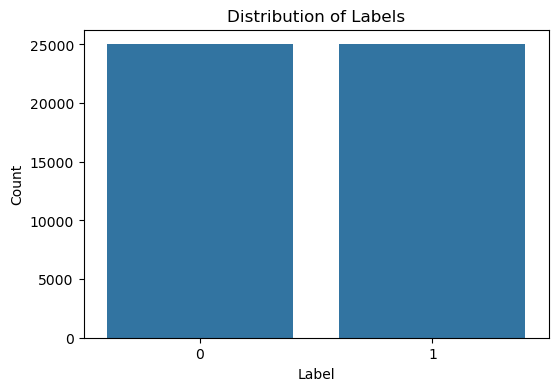

In [14]:
label_counts = data['label'].value_counts()
print(label_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Word Cloud for Text Visualization

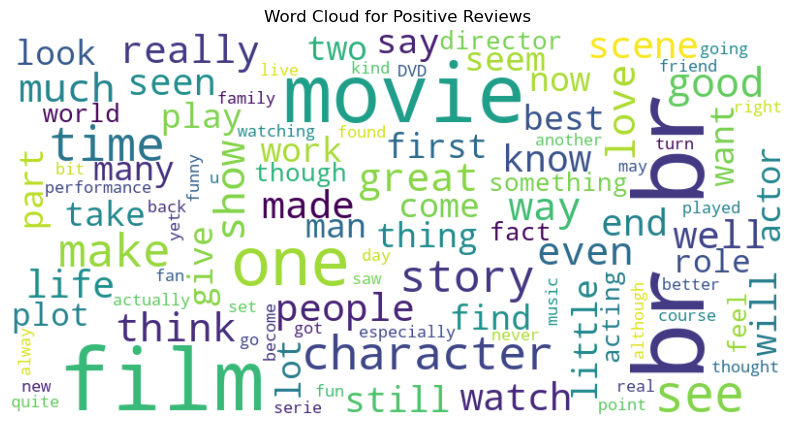

In [15]:
# Generate word cloud for positive reviews
positive_reviews = " ".join(review for review in data[data['label'] == 1]['review'])
wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color="white").generate(positive_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

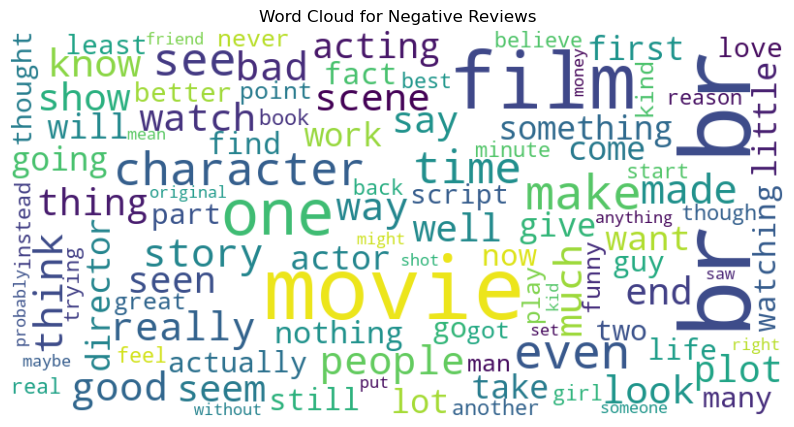

In [16]:
# Generate word cloud for negative reviews
negative_reviews = " ".join(review for review in data[data['label'] == 0]['review'])
wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color="white").generate(negative_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

### Text Length Distribution

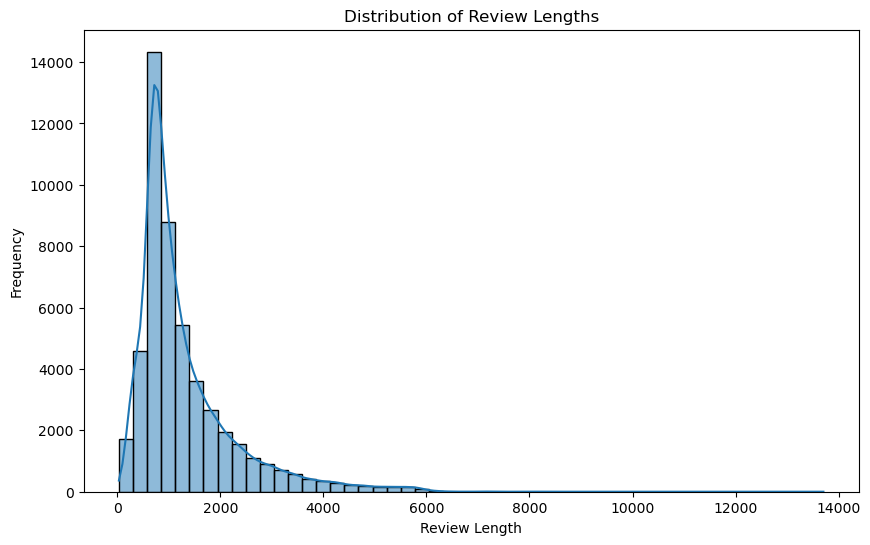

In [17]:
plt.figure(figsize=(10, 6))
review_lengths = data['review'].apply(len)
sns.histplot(review_lengths, bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

#### Findings from Data Exploration

1. **No Missing Values**: 
The dataset contains no missing values, ensuring that all entries are complete.

2. **Duplicate Entries**: 
There are a few duplicate entries in datasets (418), but the number is small and not significant enough to affect the model's performance. Therefore, chose to retain these duplicates.

3. **Balanced Dataset**: 
The dataset is balanced, with an equal distribution of positive and negative reviews, which is ideal for binary classification tasks.

4. **HTML Tags and Special Characters**: 
The reviews contain HTML tags and special characters, which need to be removed during preprocessing to ensure the text data is clean and ready for model training.

5. **Text Length Distribution**: 
The distribution of review lengths is skewed to the left, indicating that most reviews are relatively short, with a longer tail to the right representing some very long reviews. This skewness suggests that the majority of reviews are concise.


## Data Preprocessing

### Cleaning

#### Function to clean reviews

In [18]:
def clean_html_and_special_chars(review):
    # Remove HTML tags
    review = BeautifulSoup(review, "html.parser").get_text()
    
    # Remove non-alphabetic characters
    review = re.sub("[^a-zA-Z]", " ", review)
    
    return review

#### Apply the cleaning function to the dataset

In [19]:
data['review'] = data['review'].apply(clean_html_and_special_chars)

#### Display a sample of the cleaned data

In [20]:
data.sample(10)

,review,label
6694,The wind and the lion is a marvelous sweeping ...,1
22403,Now this film isn t going to scare anyone but...,0
14238,It s become extremely difficult to find a good...,1
14214,Not the greatest film to remember Paul Naschy ...,0
49209,I picked up a DVD at the discount having n...,1
46791,The magnitude of the Stalingrad tragedy is con...,1
31180,Anybody who has ever been a fan of the origina...,0
6388,Nothing really unpredictable in this movie bu...,1
29228,Possible Spoilers Perhaps I must say that C...,0
34735,What of Domino did I hate over everything and...,0


### Tokenization

#### Download punkt tokenizer

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/achshahrm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Function to tokenize reviews

In [22]:
def tokenize_review(review):
    tokens = nltk.word_tokenize(review)
    return tokens

#### Apply the tokenize function to the dataset

In [23]:
data['review'] = data['review'].apply(tokenize_review)

#### Display a sample of the tokenized data

In [24]:
data.sample(10)

,review,label
46598,"[An, original, uncensored, print, of, this, am...",1
40028,"[Well, I, like, to, be, honest, with, all, the...",0
41194,"[I, couldn, t, stand, to, watch, very, much, o...",0
14366,"[Firstly, let, me, make, it, clear, that, I, l...",0
37776,"[The, Domino, Principle, is, without, question...",0
2737,"[Well, were, to, start, This, is, by, far, one...",0
29885,"[First, things, first, I, was, never, once, sc...",1
15493,"[This, movie, was, such, a, waste, of, my, mon...",0
4627,"[I, only, watched, this, because, it, starred,...",1
20132,"[Being, a, fan, of, the, series, I, thought, h...",0


### Stop Words Removal

#### Download stopwords

In [25]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/achshahrm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Function to remove stop words

In [26]:
def remove_stop_words(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

#### Apply the remove stop words function to the dataset

In [27]:
data['review'] = data['review'].apply(remove_stop_words)

#### Display a sample data

In [28]:
data.sample(10)

,review,label
41847,"[terrible, remake, marginal, well, liked, movi...",0
43155,"[st, watched, Dir, Eugene, Levy, Corny, comedy...",0
32092,"[movie, realistic, Absolutely, belong, Hollywo...",1
31184,"[actually, pretty, bad, film, ideology, perver...",0
40584,"[film, huge, stars, good, cast, filled, excell...",0
16436,"[guess, Gunslinger, quite, god, awful, movies,...",0
36016,"[NBC, Thank, God, network, may, trying, replic...",0
4420,"[saw, film, Toronto, international, film, fest...",1
38810,"[saw, IMDb, users, rated, movie, bottom, movie...",0
31454,"[films, like, Anchors, Aweigh, bestowed, many,...",1


### Lemmatization

#### Download necessary NLTK data

In [29]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/achshahrm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/achshahrm/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Initialize the lemmatizer

In [30]:
lemmatizer = WordNetLemmatizer()

#### Function to apply lemmatization

In [31]:
def lemmatize_tokens(tokens):
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

#### Apply the lemmatization function to the dataset

In [32]:
data['review'] = data['review'].apply(lemmatize_tokens)

#### Display a sample of the lemmatized data

In [33]:
data.sample(10)

,review,label
30918,"[Normally, motivated, write, review, movie, ex...",0
6363,"[say, m, Erika, Eleniak, favorite, blonde, gir...",1
36252,"[Sure, like, bad, movie, one, time, another, f...",0
19926,"[lover, B, movie, give, genetically, mutated, ...",0
8239,"[auteur, give, credit, main, title, credit, mo...",0
26772,"[movie, pathetic, poorly, directed, acted, sun...",0
6168,"[may, one, review, movie, minute, pure, boredo...",0
20080,"[trying, hard, fit, scary, space, comedy, genr...",0
22873,"[seasoned, actor, know, act, proved, Director,...",0
35938,"[word, movie, really, suck, like, TV, Movies, ...",0


### Encoding

#### Combine tokens back into single string

In [34]:
data['review'] = data['review'].apply(lambda x: ' '.join(x))

#### Split the data into training, validation and testing sets

In [35]:
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

#### Tokenization and Padding for LSTM

In [36]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['review'])

X_train_seq = tokenizer.texts_to_sequences(train_data['review'])
X_val_seq = tokenizer.texts_to_sequences(val_data['review'])
X_test_seq = tokenizer.texts_to_sequences(test_data['review'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

y_train = np.array(train_data['label'])
y_val = np.array(val_data['label'])
y_test = np.array(test_data['label'])

#### TF-IDF Transformation for SVM and Naive Bayes

In [37]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_data['review'])
X_val_tfidf = vectorizer.transform(val_data['review'])
X_test_tfidf = vectorizer.transform(test_data['review'])

## Model Development

### Naive Bayes

#### Define the model

In [38]:
nb_model = MultinomialNB()

#### Train the model with default hyperparameters

In [39]:
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

#### Evaluate on validation set

In [40]:
nb_val_pred = nb_model.predict(X_val_tfidf)
print("Validation Accuracy for Naive Bayes:", accuracy_score(y_val, nb_val_pred))
print(classification_report(y_val, nb_val_pred))

Validation Accuracy for Naive Bayes: 0.8478
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2468
           1       0.85      0.85      0.85      2532

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



## Random Forest

#### Define the model

In [41]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

#### Train the model with default hyperparameters

In [42]:
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

#### Evaluate on validation set

In [43]:
rf_val_pred = rf_model.predict(X_val_tfidf)
print("Validation Accuracy for Random Forest:", accuracy_score(y_val, rf_val_pred))
print(classification_report(y_val, rf_val_pred))

Validation Accuracy for Random Forest: 0.8484
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      2468
           1       0.86      0.84      0.85      2532

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



### Support Vector Machine

#### Reducing dataset size
Due to the computational constraints of Support Vector Machines (SVM) with large datasets, the dataset size has been reduced to ensure efficient model training and evaluation.

In [44]:
X_train_tfidf.shape

(40000, 5000)

In [45]:
subset_size = 5000
X_train_subset, _, y_train_subset, _ = train_test_split(X_train_tfidf, y_train, train_size=subset_size, 
                                                        stratify=y_train, random_state=42)

#### Define the model

In [46]:
svm_model = SVC()

#### Train the model with default hyperparameters

In [47]:
svm_model.fit(X_train_subset, y_train_subset)

SVC()

#### Evaluate on validation set

In [48]:
svm_val_pred = svm_model.predict(X_val_tfidf)
print("Validation Accuracy for SVM:", accuracy_score(y_val, svm_val_pred))
print(classification_report(y_val, svm_val_pred))

Validation Accuracy for SVM: 0.8582
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2468
           1       0.84      0.89      0.86      2532

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



### LSTM

#### Define the LSTM model

In [49]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
lstm_model.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2)))
lstm_model.add(Dense(1, activation='sigmoid'))

#### Compile the model

In [50]:
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#### Print the model summary

In [51]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,420,097
Trainable params: 1,420,097
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [52]:
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val))

Epoch 1/10
1250/1250 [==============================] - 149s 115ms/step - loss: 0.3416 - accuracy: 0.8516 - val_loss: 0.3046 - val_accuracy: 0.8716
Epoch 2/10
1250/1250 [==============================] - 142s 113ms/step - loss: 0.2272 - accuracy: 0.9107 - val_loss: 0.2975 - val_accuracy: 0.8834
Epoch 3/10
1250/1250 [==============================] - 150s 120ms/step - loss: 0.1668 - accuracy: 0.9377 - val_loss: 0.3507 - val_accuracy: 0.8722
Epoch 4/10
1250/1250 [==============================] - 155s 124ms/step - loss: 0.1131 - accuracy: 0.9601 - val_loss: 0.3832 - val_accuracy: 0.8636
Epoch 5/10
1250/1250 [==============================] - 158s 126ms/step - loss: 0.0771 - accuracy: 0.9734 - val_loss: 0.5233 - val_accuracy: 0.8654
Epoch 6/10
1250/1250 [==============================] - 160s 128ms/step - loss: 0.0590 - accuracy: 0.9795 - val_loss: 0.5679 - val_accuracy: 0.8638
Epoch 7/10
1250/1250 [==============================] - 160s 128ms/step - loss: 0.0426 - accuracy: 0.9859 - val_

#### Evaluate on validation set

In [53]:
val_loss, val_accuracy = lstm_model.evaluate(X_val_pad, y_val)
print(f"Validation Accuracy: {val_accuracy:.2f}")

157/157 [==============================] - 5s 33ms/step - loss: 0.7524 - accuracy: 0.8576
Validation Accuracy: 0.86


## Model Performance Comparison

### Summary Table

In [54]:
summary_data = {
    'Model': ['Naive Bayes', 'Random Forest', 'SVM', 'LSTM'],
    'Accuracy': [0.8478, 0.8484, 0.8582, 0.8576],
    'Precision': [0.85, 0.85, 0.86, 'N/A'],
    'Recall': [0.85, 0.85, 0.86, 'N/A'],
    'F1-Score': [0.85, 0.85, 0.86, 'N/A']
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)

           Model  Accuracy Precision Recall F1-Score
0    Naive Bayes    0.8478      0.85   0.85     0.85
1  Random Forest    0.8484      0.85   0.85     0.85
2            SVM    0.8582      0.86   0.86     0.86
3           LSTM    0.8576       N/A    N/A      N/A


### Bar Plot

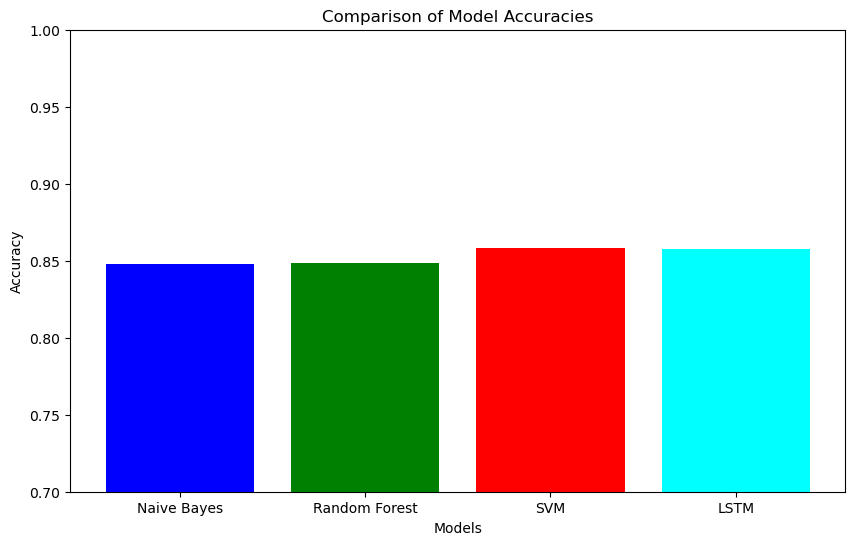

In [56]:
models = ['Naive Bayes', 'Random Forest', 'SVM', 'LSTM']
accuracies = [0.8478, 0.8484, 0.8582, 0.8576]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'cyan'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0.7, 1.0)
plt.show()

### ROC Curve

#### Get predicted probabilities

In [58]:
nb_prob = nb_model.predict_proba(X_val_tfidf)[:, 1]
rf_prob = rf_model.predict_proba(X_val_tfidf)[:, 1]
svm_prob = svm_model.decision_function(X_val_tfidf)
lstm_prob = lstm_model.predict(X_val_pad).flatten()

157/157 [==============================] - 5s 28ms/step


#### Calculate ROC curves and AUC

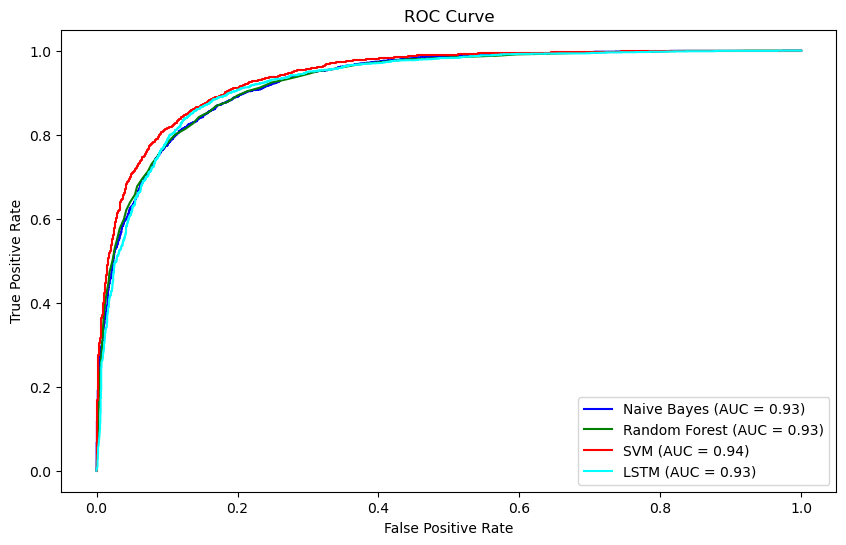

In [59]:
nb_fpr, nb_tpr, _ = roc_curve(y_val, nb_prob)
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_prob)
svm_fpr, svm_tpr, _ = roc_curve(y_val, svm_prob)
lstm_fpr, lstm_tpr, _ = roc_curve(y_val, lstm_prob)

nb_auc = auc(nb_fpr, nb_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
svm_auc = auc(svm_fpr, svm_tpr)
lstm_auc = auc(lstm_fpr, lstm_tpr)

plt.figure(figsize=(10, 6))
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})', color='blue')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='green')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})', color='red')
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.2f})', color='cyan')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### Model Performance Analysis Summary
All four models performed well, with SVM and LSTM showing slightly better results compared to the baseline models, Naive Bayes and Random Forest. Further optimization of SVM through hyperparameter tuning could enhance its accuracy. The LSTM model appears to be overfitting the training data, so applying Early Stopping and Dropout Regularization may improve its performance. In the next stage, I will focus on optimizing both the SVM and LSTM models to achieve better results.

## Optimization

### Support Vector Machines

In [62]:
# Define the model
svm_model = SVC()

# Define hyperparameters to tune
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform random search
svm_random = RandomizedSearchCV(svm_model, svm_params, cv=5, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
svm_random.fit(X_train_subset, y_train_subset)

# Best hyperparameters
print("Best Hyperparameters for SVM:", svm_random.best_params_)

Best Hyperparameters for SVM: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


#### Evaluate on validation set

In [63]:
svm_val_pred = svm_random.predict(X_val_tfidf)
print("Validation Accuracy for SVM:", accuracy_score(y_val, svm_val_pred))
print(classification_report(y_val, svm_val_pred))

Validation Accuracy for SVM: 0.8588
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      2468
           1       0.85      0.88      0.86      2532

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



#### Evaluate on test set

In [66]:
# Evaluate on test set
svm_test_pred = svm_random.predict(X_test_tfidf)
print("Test Accuracy for SVM:", accuracy_score(y_test, svm_test_pred))
print(classification_report(y_test, svm_test_pred))

Test Accuracy for SVM: 0.8582
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2489
           1       0.85      0.87      0.86      2511

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



### LSTM

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the improved LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
lstm_model.add(Bidirectional(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(units=32, dropout=0.5, recurrent_dropout=0.5)))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
lstm_history = lstm_model.fit(X_train_pad, y_train, epochs=20, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = lstm_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/20
1250/1250 [==============================] - 150s 116ms/step - loss: 0.3511 - accuracy: 0.8472 - val_loss: 0.2929 - val_accuracy: 0.8758
Epoch 2/20
1250/1250 [==============================] - 140s 112ms/step - loss: 0.2347 - accuracy: 0.9070 - val_loss: 0.3017 - val_accuracy: 0.8830
Epoch 3/20
1250/1250 [==============================] - 147s 118ms/step - loss: 0.1861 - accuracy: 0.9289 - val_loss: 0.3289 - val_accuracy: 0.8742
Epoch 4/20
157/157 [==============================] - 5s 31ms/step - loss: 0.2931 - accuracy: 0.8814
Test Accuracy: 0.88


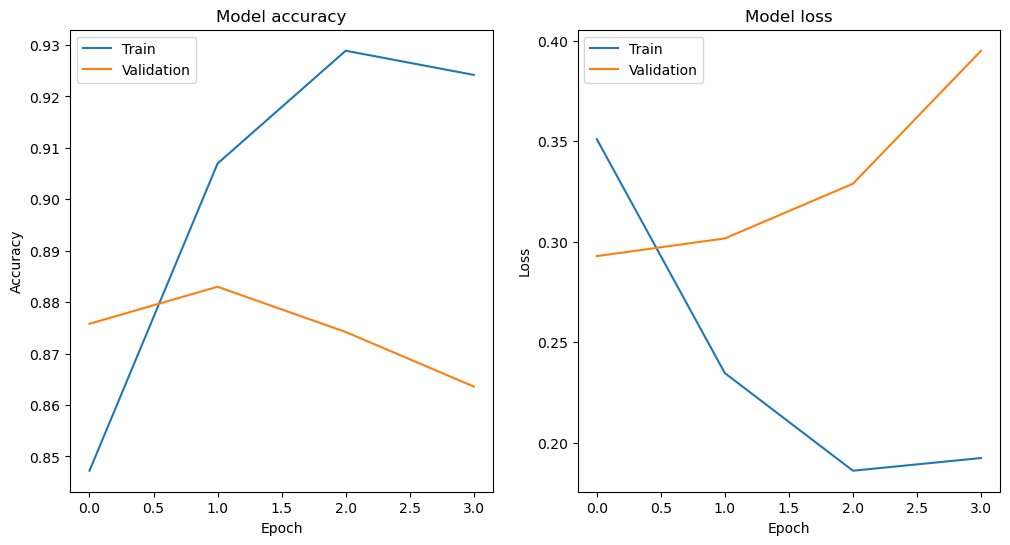

In [65]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## CONCLUSION
The optimized LSTM model achieved significant improvement, with a validation accuracy of 88.30% and a test accuracy of 88.14%. This indicates strong generalization performance. Early stopping was successfully employed to prevent overfitting, stopping the training when the validation loss ceased to improve. Given these high accuracy rates, the model is performing well, and it may be reasonable to conclude the optimization process here.

In comparison, the SVM model's performance did not show any significant improvement after optimization, with a validation accuracy of 85.88% and a test accuracy of 85.82%. Despite hyperparameter tuning, the SVM model's accuracy remained similar to its pre-optimization performance. Therefore, it can be concluded that the LSTM model outperforms the SVM model for this use case.

Further improvements could be explored through additional hyperparameter tuning, ensemble methods, or advanced architectures such as Transformers. Combining multiple weak estimators like SVM, Naive Bayes, and LSTM in an ensemble approach might also enhance overall performance. For future work, investigating these advanced models and techniques could potentially yield even better results.